In [4]:
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import gym
tf.disable_eager_execution()
print(tf.__version__)

import os
#os.environ['COLAB_SKIP_TPU_AUTH'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


2.3.1


In [14]:
env = gym.make('Breakout-v0')
obs = env.reset()
env.action_space.n
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

# Constructing the Network, Training Graph, Inference Graph

In [15]:
#define the network, though it is (state, action) --> value, we use the s --> a network
#this comes before the exploration function, because the exploration need to the Q-factor function to determine
#where to go, either with greedy step, or the epsilon-greedy step

conv_filter = [32,64,64]
conv_kernelSize = [(8,8), (4,4), (3,3)]
conv_strides = [4,2,1]
conv_paddings = ["SAME"] * 3
conv_activations = [tf.nn.relu] * 3
n_hidden = 512
n_outputs = env.action_space.n  #this is suppose to change, since there are only two actions
initializer = tf.variance_scaling_initializer(scale = 2)
learning_rate = 0.1

def construct_graph(x_state,name):
    prev_layer = x_state
    with tf.variable_scope(name) as scope:
        for i in range(3):
            prev_layer = tf.layers.conv2d(prev_layer, 
                                     filters = conv_filter[i],
                                     kernel_size = conv_kernelSize[i],
                                     strides = conv_strides[i],
                                     padding = conv_paddings[i],
                                     activation = conv_activations[i],
                                     kernel_initializer = initializer)
        conv_to_flatten = tf.layers.flatten(prev_layer)
        dense = tf.layers.dense(conv_to_flatten, n_hidden, activation = tf.nn.relu,
                               kernel_initializer = initializer)
        outputs = tf.layers.dense(dense, n_outputs, activation = None,
                               kernel_initializer = initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var for var in trainable_vars}
    
    return outputs, trainable_vars_by_name


#construct the training(online) network and the inference(target) graph
tf.reset_default_graph()

xstate = tf.placeholder(tf.float64, shape = [None, 80, 80, 1])
train_output, train_vars = construct_graph(xstate, 'q_network/train')
infer_output, infer_vars = construct_graph(xstate, 'q_network/infer')
                        
copy_ops = [infer_var.assign(train_vars[var_name]) for var_name, infer_var in infer_vars.items()]
copy_trainToInfer = tf.group(*copy_ops)

#a very small gradient clipper function


#define the training network
with tf.variable_scope('train'):
    X_action = tf.placeholder(tf.float64, shape = [None, n_outputs])
    y = tf.placeholder(tf.float64, shape = [None,1])
    
    qvalue = tf.reduce_sum(train_output * X_action, axis = 1, keepdims = True)
    error = tf.abs(y - qvalue)
    clipped_error = tf.clip_by_value(error, 0.0,1.0)
    linear_error = 2*(error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)
    
    opt = tf.train.MomentumOptimizer(learning_rate = learning_rate,
                                    momentum = 0.95,
                                    use_nesterov=True)
    
    
    train_op = opt.minimize(loss)

    

saver = tf.train.Saver()

# The replay buffer class, could preprocess, explore, sample

In [7]:
#the exploration function, generate (s,a,r,s') which will be put in the replay buffer
#to decide which a|s, choose between greedy or epsilon greedy

#the buffer class that that will have a replay buffer that enable sampling from it for (s, a ,r ,s')
# it will have method as 1, append new epsiode to the buffer 2, sample a batch giving batch size

class replayBuffer:
    def __init__(self, maxlen):
        self.buffer = deque(maxlen = maxlen)
        self.maxlen = maxlen #in case need to check later, but no use in computation
        
    def preprocess(self, image):
        """ prepro 210x160x3 uint8 frame into 6400 (80x80) 2D float array """ 
        image = image[35:195] # crop
        image = image[::2,::2,0] # downsample by factor of 2
        image[image == 144] = 0 # erase background (background type 1) 
        image[image == 109] = 0 # erase background (background type 2) 
        image[image != 0] = 1 # everything else just set to 1
        return np.reshape(image.astype(np.float).ravel(), [80,80,1])
    
    def epsilon_greedy(self, q_factor, epsilon):
        if np.random.choice([0,1],size = 1, p = [1-epsilon, epsilon]) > 0:
            action = np.random.randint(len(q_factor), size = 1)
            #print(q_factor)
            #print('length of qfactor {:d}, random action {:d}'.format(len(q_factor), action[0]))
        else:
            action = np.argmax(q_factor)
        return action
        
        
    #play epiToUpdate full games
    def updateBuffer(self, epiToUpdate, train_q_factor, epsilon, start_skip):
        #epiToUpdate, the number of full episode to sample 
        #train_q_factor, is the output node from the trainiing graph, 
        #epsilon: the epsilon parameter in the epsilon greedy algorithm
        #the number of start steps will be skipped and not join the buffer
        epiUpdated = 0
        while epiUpdated < epiToUpdate:
            #initialize the game
            next_state = env.reset()
            
            done = False 
            # to skip the first several steps not joining the buffer
            # if the game stopped earlier, break the initial warm up and break the whole epi
            for _ in range(start_skip):
                next_state, reward, done, info = env.step(0)
                if done:
                    print("An episode is skipped due to the game ends before warm up finishes")
                    break
            
            #if after the warm up the episode not end, then count this episode
            if not done:
                epiUpdated += 1
                
                
            cur_state = self.preprocess(next_state)
            
            total_q_max = 0
            total_reward = 0
            game_length = 0
            
                
            while not done:
                
                q_factor = train_q_factor.eval(feed_dict={xstate: [cur_state]})[0]
                action= self.epsilon_greedy(q_factor, epsilon)
            
                action_onehot = np.zeros(train_q_factor.shape[1])
                action_onehot[action] = 1
               
                #even though the epsilon greedy might not take this action, 
                #we take the greedy reward to measure performance
                total_q_max += np.max(q_factor)
                
                #!!!!!!!!!this +2 is due to the property of action indices
                next_state, reward, done, info = env.step(action) 
                next_state = self.preprocess(next_state)
            #print(done)
                self.buffer.append([cur_state, action_onehot, reward, next_state, done])
                cur_state = next_state
                total_reward += reward
                game_length += 1
                
            
            
        if epiToUpdate == 1:
            return game_length, total_q_max/game_length, total_reward/game_length
                
            
        
    def sample(self, batch_size, replace = True):
        cols = [[],[],[],[],[]]
        indices = np.random.choice(a = len(self.buffer), size = batch_size, replace = replace)
        for ind in indices:
            for col, value in zip(cols, self.buffer[ind]):
                col.append(value)
        cols = [np.array(col) for col in cols]
        return cols[0], cols[1], cols[2].reshape(-1,1), cols[3], cols[4].reshape(-1,1)


# The main file for training

In [8]:
#for step_level1:
    #expand the buffer by epsilon gready algrithm
    #for step_level2:
        #assign train var to infer var
        #for step_level3:
            #sample batch size from buffer
            #update the train var

buffer_size = 50000
start_skip = 90
batch_size = 500
step_level1 = 1 #play game number
step_level2 = 5 # update inference
step_level3 = 5 # gradient step
discount = 0.95
checkpoint_path = './my_dgn.ckpt'  


with tf.Session() as sess:
    #initialize all the graphs
    
    if os.path.isfile(checkpoint_path + '.index'):
        saver.restore(sess, checkpoint_path)
        print('restore from file')
    else:
        init = tf.global_variables_initializer()
        init.run()
        copy_trainToInfer.run()
    
    #construct the buffer
    replay_buff = replayBuffer(buffer_size)
    #since warm up, the epsilon = 1, i.e taking uniform random actions
    replay_buff.updateBuffer(5, train_output, epsilon = 1, start_skip = 0)
    #print('Initial run 5 full games and now the buffer has {:d} memory'.format(len(replay_buff.buffer)))
    
    score_seq = []
    count1 = 0
    for _ in range(step_level1):
        
        count1 += 1
        
        # the decreasing epsilon greedy strategy when training proceed, highest epi = 0.5
        cur_epsilon = 0.5 * (1 - count1/step_level1)
        
        gamelen, score, re = replay_buff.updateBuffer(1, train_output, epsilon = cur_epsilon, start_skip = start_skip)
        
        
        #print('Play game {:d}({:.02%}); game length: {:d}; average qfactor: {:f}; average reward: {:f}; buffer size: {:d}'.format(count1,\
        #                                        count1/step_level1, gamelen, score, re, len(replay_buff.buffer)))
        score_seq.append(score)
        
        
        for _ in range(step_level2):
            # update the inference graph as the train graph
            copy_trainToInfer.run()
            
            
            for _ in range(step_level3):
                #sample batch_size from the buffer        
                cur_state, action, reward, next_state, status = replay_buff.sample(batch_size, replace = True)
                
                #print(nextstate.dtype)
                #print(type(nextstate))
                #print(nextstate.shape)
                
                next_q_value = sess.run(infer_output, feed_dict = {xstate: next_state})
                max_next_q_value = np.max(next_q_value, axis = 1, keepdims = True)
                y_val = reward + status * discount * max_next_q_value
                
                #print(action.shape)
                ##print(cur_state)
                #print(y_val)
                
                sess.run([train_op], feed_dict={xstate: cur_state,
                                                X_action: action,
                                                y:y_val})
        
        if count1 % 100 == 0:
            saver.save(sess, checkpoint_path)
                
                

    
    
    
    
    
    
    
    
    
    

# After training, play  the game using the trained network

In [32]:
import pickle
temp1 = pickle.load( open( "./HW3/problem1.pickle", "rb" ) )

qFactor = temp1[0]
reward = temp1[1]



True
INFO:tensorflow:Restoring parameters from ./HW3/problem1.ckpt
restored from the file


In [19]:
replay_buff = replayBuffer(100)


In [27]:
def playGame():
        
    cur_state = replay_buff.preprocess(env.reset())
            
    done = False 
           
    total_reward = 0
           
                
    while not done:
                
        q_factor = train_output.eval(feed_dict={xstate: [cur_state]})[0]
        action= np.argmax(q_factor)
            
        action_onehot = np.zeros(train_output.shape[1])
        action_onehot[action] = 1
               
                
        #!!!!!!!!!this +2 is due to the property of action indices
        next_state, reward, done, info = env.step(action) 
        next_state = replay_buff.preprocess(next_state)
           
        cur_state = next_state
        total_reward += reward
    return reward    
                

                

In [30]:
with tf.Session() as sess:
    if os.path.isfile('./HW3/problem1.ckpt.index'):
        print(True)
        saver.restore(sess, './HW3/problem1.ckpt')
        print('restored from the file')
    
    score_seq = []
    for _ in range(1000):
        score_seq.append(playGame())

True
INFO:tensorflow:Restoring parameters from ./HW3/problem1.ckpt
restored from the file


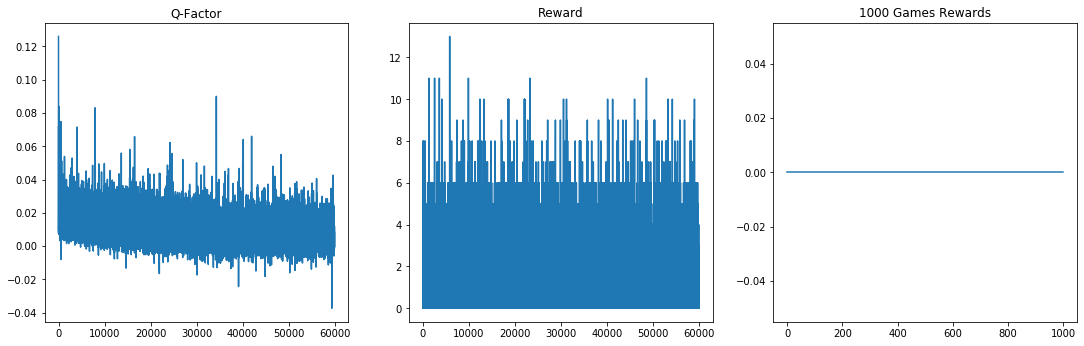

In [37]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(18.5, 5.5)
ax[0].plot(range(len(qFactor)), qFactor)
ax[1].plot(range(len(reward)), reward)
ax[2].plot(range(len(score_seq)), score_seq)

ax[0].set_title('Q-Factor')
ax[1].set_title('Reward')
ax[2].set_title('1000 Games Rewards')


plt.show()